In [1]:
'''
Writing this script such that if I run it with input parameters, 
it should give me element centric similarity for the methods, we query
each method we query can run withinn this or out. Will decide.
Use chanage_mu_test.py as reference.
'''
import numpy as np
from scipy import sparse
import pandas as pd
#import os
#import networkx as nx
#import gensim
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.linear_model import LogisticRegression 
import faiss
import fast_hdbscan
#import lfr
#import embcom
#import csv
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.nets_and_embeddings import create_and_save_network_and_embedding
#from scripts.clustering_methods import clustering_method_values
from scripts.nets_and_embeddings import load_net_and_embedding

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
import numpy as np
import belief_propagation
import infomap
from graph_tool.all import Graph,minimize_blockmodel_dl

# Need net, node_table and emb files
# net is G, emb files are wv, node_table probably
# has some info about ground truth community labels or smth like that.

# Define a function that calculates element-centric similarity:
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected

def find_knn_edges(emb, num_neighbors, 
                   target=None, metric="dotsim",
                   device=None):
    
    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    indices, distances = find_knn(emb if target is None else target, emb,
                                  num_neighbors=k,
                                  metric=metric,
                                  device=device)
    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(int)
    r, c, distances = (r.reshape(-1),indices.astype(int).reshape(-1),distances.reshape(-1))
    if len(r) == 0:
        return r, c, distances 
    
    return r, c, distances

# Only place where GPU is used, need to handle its closing. 
def find_knn(target, emb, num_neighbors, metric="dotsim", device=None): 
    if metric == "dotsim":
        index = faiss.IndexFlatIP(emb.shape[1]) 
    elif metric == "euclidean":
        index = faiss.IndexFlatL2(emb.shape[1])
    elif metric == "manhattan":
        index = faiss.IndexFlatL1(emb.shape[1])
    elif metric == "cosine":
        index = faiss.IndexFlatIP(emb.shape[1])
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    elif metric=="mahalanobis":
        # THis mathematical trick works, but it needs some reworking in target.astype to
        # give right results.
        # map the vectors back to a space where they follow a unit Gaussian
        xc = emb - emb.mean(0)
        cov = np.dot(xc.T, xc) / xc.shape[0]
        L = np.linalg.cholesky(cov)
        mahalanobis_transform = np.linalg.inv(L)
        emb = np.dot(emb, mahalanobis_transform.T)
        index = faiss.IndexFlatL2(emb.shape[1])
    else:
        raise ValueError("Invalid metric specified.")
    
    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
        # This line takes too long to load.
    else: 
        try:
            gpu_id = int(device[-1])
            res = faiss.StandardGpuResources()
            index = faiss.index_cpu_to_gpu(res, gpu_id, index)
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
        except RuntimeError:
            if metric == "dotsim":
                index = faiss.IndexFlatIP(emb.shape[1]) 
            elif metric == "euclidean":
                index = faiss.IndexFlatL2(emb.shape[1])
            elif metric == "manhattan":
                index = faiss.IndexFlatL1(emb.shape[1])
            elif metric == "cosine":
                index = faiss.IndexFlatIP(emb.shape[1])
                emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
            else:
                raise ValueError("Invalid metric specified.")
            
            index.add(emb.astype(np.float32))
            distances, indices = index.search(target.astype(np.float32),
                                              k=num_neighbors)
        
    index.reset()
    return indices, distances

import numba

def louvain(Z, w1, b0, num_neighbors=100, iteration = 50, device = "cuda:0", return_member_matrix=False):
    """"Louvain algorithm for vecto data
    :param Z: embedding
    :type Z: numpy.ndarray
    :param w1: regression coefficient
    :type w1: float
    :param b0: intercept
    :type b0: float
    :param num_neighbors: Number of neighbors, defaults to 100
    :type num_neighbors: int, optional
    :param iteration: The maximum number of iterations, defaults to 50
    :type iteration: int, optional
    :param device: _description_, defaults to "cuda:0"
    :type device: str, optional
    :param return_member_matrix: _description_, defaults to False
    :type return_member_matrix: bool, optional
    :return: _description_
    :rtype: _type_
    """
    # Initialize the intermediate variables
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()
    
    # The main loop for the Louvain algorithm
    while True:
        # Find the community assignment for the given graph # using a label switching algorithm
        cids_t = label_switching(
               Z=Vt,
               num_neighbors=num_neighbors,
               rho=b0/w1,
               node_size=node_size,
               epochs=iteration,
               device=device,
                )
        
        # This is to make the community labels continuous integer variables
        _, cids_t = np.unique(cids_t, return_inverse=True)
        
        # If no merging, we are good to go out from the loop
        if int(max(cids_t) + 1) == Vt.shape[0]: 
            break
            
        # If two nodes are merged, we created an aggregated network, 
        #where a node represents a community.
        
        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        
        node_size = np.array(Ut.T @ node_size).reshape(-1)
    if return_member_matrix: 
        return U
    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(-1)

    return cids

#
# Clustering based on a label switching algorithm
#
def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None,epochs=50): # This involves distance metrics (cosine similarity, atm)
    num_nodes, dim = Z.shape
    if node_size is None:
        node_size = np.ones(num_nodes)
    Z = Z.copy(order="C").astype(np.float32)
    # Construct the candidate graph
    Z1 = np.hstack([Z, np.ones((num_nodes, 1))])
    Zrho = np.hstack([Z, -rho * node_size.reshape((-1, 1))])

    r, c, v = find_knn_edges(
        Zrho,
        target=Z1,
        num_neighbors=num_neighbors,
        metric="cosine",
        device=device)
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))
    
    return _label_switching_(
        A_indptr=A.indptr,
        A_indices=A.indices,
        Z=Z,
        num_nodes=num_nodes,
        rho=rho,
        node_size=node_size,
        epochs=epochs)

#@numba.jit(nopython=True, cache=True)
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size,epochs=100):
    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()
    Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1) 
    for nid in range(num_nodes):
            Nc[nid] += node_size[nid]
    for _it in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False) 
        updated_node_num = 0
        
        for _k, node_id in enumerate(order):
            # Get the weight and normalized weight
            neighbors = A_indices[A_indptr[node_id] : A_indptr[node_id + 1]]

            # Calculate the grain
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1
            dqmax = 0
            qself = (
                np.sum(Z[node_id, :] * Vc[c, :])
                - Vnorm[node_id]
                - rho * node_size[node_id] * (Nc[c] - node_size[node_id]))

            for cprime in clist:
                if c == cprime: 
                    continue
                dq = (np.sum(Z[node_id, :] * Vc[cprime, :])
                        - rho * node_size[node_id] * Nc[cprime]) - qself
                if dqmax < dq:
                    next_cid = cprime
                    dqmax = dq
            if dqmax <= 1e-16: 
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / np.maximum(1, num_nodes)) < 1e-3: 
            break
    return cids

# def proposed_method_labels(emb,device_name):
#         rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=200, device = device_name) # this might involve distance metrics
#         cneg = np.random.choice(emb.shape[0], len(cpos))
#         vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

#         model = LogisticRegression()
#         model.fit(
#             np.concatenate([vpos, vneg]).reshape((-1, 1)),
#             np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
#                 )
#         w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
#         return louvain(emb, w1, b0, device = device_name) # this might involve distance metrics

    # Evaluate the clustering

In [9]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import check_random_state
from numba import njit

class CustomKMeans:
    def __init__(self, n_clusters, metric='euclidean', max_iter=300, tol=1e-4, random_state=None, n_init=10, init='k-means++', batch_size=None):
        self.n_clusters = n_clusters
        self.metric = metric
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.n_init = n_init
        self.init = init
        self.batch_size = batch_size  # Mini-batch size, if any

    def calculate_distances(self, X, centroids):
        """Optimized distance calculation for the specified metric."""
        if self.metric == 'euclidean':
            return cdist(X, centroids, metric='euclidean')
        elif self.metric == 'manhattan':
            return cdist(X, centroids, metric='cityblock')
        elif self.metric == 'cosine':
            return 1 - cosine_similarity(X, centroids)
        elif self.metric == 'dot':
            return -np.dot(X, centroids.T)
        elif self.metric == 'geodesic':
            # Calculate geodesic distance as arccos(cosine_similarity) for normalized data
            cos_sim = cosine_similarity(X, centroids)
            # Clip values to avoid out-of-domain errors in arccos
            cos_sim = np.clip(cos_sim, -1.0, 1.0)
            return np.arccos(cos_sim)
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

    def _initialize_centroids(self, X, rng):
        """Efficient k-means++ initialization."""
        centroids = [X[rng.randint(X.shape[0])]]
        closest_dist_sq = self.calculate_distances(X, np.array(centroids))[:, 0] ** 2

        for _ in range(1, self.n_clusters):
            probs = closest_dist_sq / closest_dist_sq.sum()
            cumulative_probs = np.cumsum(probs)
            r = rng.rand()
            new_centroid = X[np.searchsorted(cumulative_probs, r)]
            centroids.append(new_centroid)
            new_dist_sq = self.calculate_distances(X, np.array([new_centroid]))[:, 0] ** 2
            closest_dist_sq = np.minimum(closest_dist_sq, new_dist_sq)
        
        return np.array(centroids)

    @staticmethod
    @njit
    def _update_centroids(X, labels, n_clusters):
        """Compute new centroids using JIT compilation for efficiency."""
        new_centroids = np.zeros((n_clusters, X.shape[1]), dtype=X.dtype)
        counts = np.zeros(n_clusters, dtype=np.int64)
        
        for i in range(X.shape[0]):
            new_centroids[labels[i]] += X[i]
            counts[labels[i]] += 1
        
        for j in range(n_clusters):
            if counts[j] > 0:
                new_centroids[j] /= counts[j]
        
        return new_centroids

    def _run_kmeans(self, X, rng):
        """Run a single instance of K-means clustering with optional mini-batch."""
        centroids = self._initialize_centroids(X, rng)
        n_samples = X.shape[0]

        for i in range(self.max_iter):
            if self.batch_size:
                batch_indices = rng.choice(n_samples, self.batch_size, replace=False)
                X_batch = X[batch_indices]
                distances = self.calculate_distances(X_batch, centroids)
                labels = np.argmin(distances, axis=1)
            else:
                distances = self.calculate_distances(X, centroids)
                labels = np.argmin(distances, axis=1)
            
            new_centroids = self._update_centroids(X, labels, self.n_clusters)
            
            # Convergence check based on relative tolerance
            centroid_shifts = np.linalg.norm(new_centroids - centroids, axis=1)
            if np.all(centroid_shifts < self.tol * np.linalg.norm(centroids, axis=1)):
                break
            
            centroids = new_centroids
        
        # Inertia calculation for this run
        inertia = np.sum(np.min(distances, axis=1) ** 2)
        return centroids, labels, inertia

    def fit(self, X):
        """Run KMeans with multiple initializations to get the best clustering."""
        best_inertia = np.inf
        best_centroids = None
        best_labels = None
        rng = check_random_state(self.random_state)

        for _ in range(self.n_init):
            centroids, labels, inertia = self._run_kmeans(X, rng)
            
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
        
        # Set final results
        self.centroids_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to."""
        distances = self.calculate_distances(X, self.centroids_)
        return np.argmin(distances, axis=1)


In [7]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.sparse import find
from sklearn.linear_model import LogisticRegression
import fast_hdbscan  # Assuming fast_hdbscan is a placeholder for the actual import
#from custom_kmeans import CustomKMeans  # Importing modified K-means with metrics
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

def clustering_method_values(net, community_table, emb, score_keys, device_name):
    # Normalize the vector of each node to have unit length. This normalization improves clustering.
    X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()

    def proposed_method_labels(emb, device_name):
        rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=500, device=device_name)
        cneg = np.random.choice(emb.shape[0], len(cpos))
        vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

        model = LogisticRegression()
        model.fit(
            np.concatenate([vpos, vneg]).reshape((-1, 1)),
            np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
        )
        w1, b0 = model.coef_[0, 0], -model.intercept_[0]
        return louvain(emb, w1, b0, device=device_name)

    def method_score(key):
        if key == "kmeans":
            kmeans = KMeans(n_clusters=len(set(community_table["community_id"])), random_state=0).fit(X)
            return calc_esim(community_table["community_id"], kmeans.labels_)

        elif key.startswith("kmeans_"):  # Parse metric and apply CustomKMeans with modified metrics
            metric = key.split("_", 1)[1]
            custom_kmeans = CustomKMeans(n_clusters=len(set(community_table["community_id"])), metric=metric, random_state=0).fit(emb)
            return calc_esim(community_table["community_id"], custom_kmeans.labels_)

        elif key == "dbscan":
            clusterer = fast_hdbscan.HDBSCAN(min_cluster_size=len(set(community_table["community_id"])))
            dbscan_labels = clusterer.fit_predict(X)
            return calc_esim(community_table["community_id"], dbscan_labels)

        elif key == "optics":
            optics = OPTICS().fit(X)
            return calc_esim(community_table["community_id"], optics.labels_)

        elif key == "proposed":
            return calc_esim(community_table["community_id"], proposed_method_labels(emb, device_name))

        elif key == "xmeans":
            initial_centers = kmeans_plusplus_initializer(X, amount_centers=len(set(community_table['community_id']))).initialize()
            xmeans_mndl = xmeans(X, initial_centers, 20, splitting_type=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH)
            xmeans_mndl.process()
            mndl_clusters = xmeans_mndl.get_clusters()
            xmeans_labels = [i[1] for i in sorted([(j, i) for i in range(len(mndl_clusters)) for j in mndl_clusters[i]])]
            return calc_esim(community_table["community_id"], xmeans_labels)

        elif key == "belief_prop":
            belief_prop_labels = belief_propagation.detect(net, q=len(set(community_table['community_id'])), init_memberships=community_table["community_id"])
            return calc_esim(community_table["community_id"], belief_prop_labels)

        elif key == "infomap":
            r, c, v = find(net + net.T)
            im = infomap.Infomap(silent=True)
            for i in range(len(r)):
                im.add_link(r[i], c[i], 1)
            im.run()

            cids = np.zeros(net.shape[0])
            for node in im.tree:
                if node.is_leaf:
                    cids[node.node_id] = node.module_id

            infomap_labels = np.unique(cids, return_inverse=True)[1]
            return calc_esim(community_table["community_id"], infomap_labels)

        elif key == "flatsbm":
            r, c, v = find(net)
            g = Graph(directed=False)
            g.add_edge_list(np.vstack([r, c]).T)
            K = len(set(community_table['community_id']))
            state = minimize_blockmodel_dl(
                g,
                state_args={"B_min": K, "B_max": K},
                multilevel_mcmc_args={"B_max": K, "B_min": K},
            )
            b = state.get_blocks()
            flatsbm_labels = np.unique(np.array(b.a), return_inverse=True)[1]
            return calc_esim(community_table["community_id"], flatsbm_labels)

    # Calculate and store scores for each clustering method in score_keys
    score_dictionary = {}
    for key in score_keys:
        score_dictionary[key] = method_score(key)

    return score_dictionary

In [8]:
N=10000
mu_values = np.round(np.arange(0.05, 1.05, 0.05),decimals=2)

params = {
    "N": N,
    "k": 5,
    "maxk":  int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
    "mu": 0.2,
    }


emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

run_no = 1
path_name= f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_5_3.0_minc50/Run_{run_no}/"

#"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_0.1_k_50_mincomm_50.npz"

net, community_table, emb = load_net_and_embedding(params, emb_params, path_name)

score_keys=['kmeans_geodesic']
clustering_method_values(net, community_table, emb, score_keys, device_name = "cuda:0")

{'kmeans_geodesic': 0.0022404790618568695}

(array([  72., 1977., 3578., 1699.,  876.,  689.,  582.,  355.,  144.,
          28.]),
 array([1.91389007, 2.05588716, 2.19788424, 2.33988133, 2.48187842,
        2.6238755 , 2.76587259, 2.90786968, 3.04986676, 3.19186385,
        3.33386094]),
 <BarContainer object of 10 artists>)

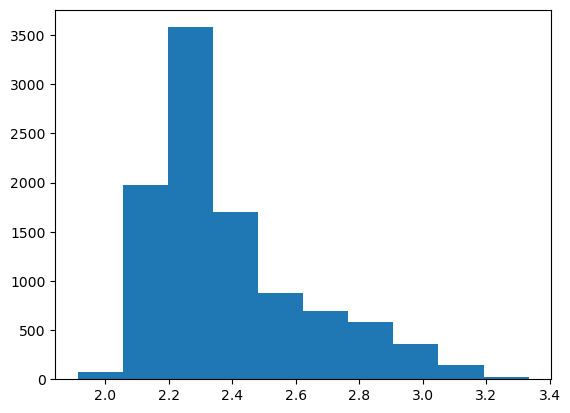

In [9]:
import matplotlib.pyplot as plt
norm_arr = [np.linalg.norm(i) for i in emb ]
plt.hist(norm_arr)

In [10]:
import os
import numpy as np
import pandas as pd
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
import torch
# Assuming `load_net_and_embedding` and `clustering_method_values` are defined elsewhere

# Parameters
N = 10000
mu_values = np.round(np.arange(0.05, 1.05, 0.05), decimals=2)
params_template = {
    "N": N,
    "k": 50,
    "maxk": int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
}
emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}
score_keys = ['kmeans_geodesic']

# Output file path
output_file = "/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0_minc50/kmeans_clustering_metric_geodesic.txt"

# Prepare output directory if necessary
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Function to process a single run and mu value
def process_run(run_no, mu):
    torch.cuda.set_device(0)  # Or cp.cuda.Device(0).use() if using CuPy

    params = params_template.copy()
    params["mu"] = mu

    # Path for the current run
    path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0_minc50/Run_{run_no}/"

    # Load data
    net, community_table, emb = load_net_and_embedding(params, emb_params, path_name)

    # Compute clustering scores
    result = clustering_method_values(net, community_table, emb, score_keys, device_name="cuda:0")

    # Format results as CSV line
    result_values = [result[key] for key in score_keys]
    result_str = f"{run_no},{mu}," + ",".join(map(str, result_values))

    # Print progress
    print(f"Completed Run {run_no} with Mu {mu}")

    return result_str

# Function to process all runs and mu values in parallel
def process_all_combinations_parallel():
    # Generate all combinations of run numbers and mu values
    runs_mu_combinations = [(run_no, mu) for run_no in range(1, 11) for mu in mu_values]
    total_combinations = len(runs_mu_combinations)

    # Start time
    start_time = time.time()

    # Write header to output file
    with open(output_file, "w") as f:
        header = "run_no,mu," + ",".join(score_keys) + "\n"
        f.write(header)

    # Use ProcessPoolExecutor to parallelize the processing
    with ProcessPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(process_run, run_no, mu): (run_no, mu) for run_no, mu in runs_mu_combinations}
        
        # As each task completes, write its result to the file
        with open(output_file, "a") as f:
            for idx, future in enumerate(as_completed(futures), start=1):
                run_no, mu = futures[future]
                try:
                    result_str = future.result()  # Get the result of the completed future
                    f.write(result_str + "\n")  # Append the result to the file
                    print(f"Processed {idx}/{total_combinations} combinations: Run {run_no}, Mu {mu}")
                except Exception as e:
                    print(f"Error processing Run {run_no}, Mu {mu}: {e}")
    
    # Total elapsed time
    total_elapsed_time = time.time() - start_time
    print(f"All combinations processed in parallel. Total elapsed time: {total_elapsed_time:.2f} seconds.")

# Run the parallel processing for all combinations
if __name__ == "__main__":
    process_all_combinations_parallel()


Completed Run 1 with Mu 0.65
Processed 1/200 combinations: Run 1, Mu 0.65
Completed Run 1 with Mu 0.45
Processed 2/200 combinations: Run 1, Mu 0.45
Completed Run 1 with Mu 0.2
Processed 3/200 combinations: Run 1, Mu 0.2
Completed Run 1 with Mu 0.05
Processed 4/200 combinations: Run 1, Mu 0.05
Completed Run 1 with Mu 0.15
Processed 5/200 combinations: Run 1, Mu 0.15
Completed Run 1 with Mu 0.6
Processed 6/200 combinations: Run 1, Mu 0.6
Completed Run 1 with Mu 0.7
Processed 7/200 combinations: Run 1, Mu 0.7
Completed Run 1 with Mu 0.35
Completed Run 1 with Mu 0.1
Processed 8/200 combinations: Run 1, Mu 0.35
Processed 9/200 combinations: Run 1, Mu 0.1
Completed Run 1 with Mu 0.55
Processed 10/200 combinations: Run 1, Mu 0.55
Completed Run 1 with Mu 0.5
Processed 11/200 combinations: Run 1, Mu 0.5
Completed Run 1 with Mu 0.25
Processed 12/200 combinations: Run 1, Mu 0.25
Completed Run 1 with Mu 0.3
Processed 13/200 combinations: Run 1, Mu 0.3
Completed Run 1 with Mu 0.4
Processed 14/200 c

In [11]:
import os
import numpy as np
import pandas as pd
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
import torch
# Assuming `load_net_and_embedding` and `clustering_method_values` are defined elsewhere

# Parameters
N = 10000
mu_values = np.round(np.arange(0.05, 1.05, 0.05), decimals=2)
params_template = {
    "N": N,
    "k": 5,
    "maxk": int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
}
emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}
score_keys = ['kmeans_geodesic']

# Output file path
output_file = "/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_5_3.0_minc50/kmeans_clustering_metric_geodesic.txt"

# Prepare output directory if necessary
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Function to process a single run and mu value
def process_run(run_no, mu):
    torch.cuda.set_device(0)  # Or cp.cuda.Device(0).use() if using CuPy

    params = params_template.copy()
    params["mu"] = mu

    # Path for the current run
    path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_5_3.0_minc50/Run_{run_no}/"

    # Load data
    net, community_table, emb = load_net_and_embedding(params, emb_params, path_name)

    # Compute clustering scores
    result = clustering_method_values(net, community_table, emb, score_keys, device_name="cuda:0")

    # Format results as CSV line
    result_values = [result[key] for key in score_keys]
    result_str = f"{run_no},{mu}," + ",".join(map(str, result_values))

    # Print progress
    print(f"Completed Run {run_no} with Mu {mu}")

    return result_str

# Function to process all runs and mu values in parallel
def process_all_combinations_parallel():
    # Generate all combinations of run numbers and mu values
    runs_mu_combinations = [(run_no, mu) for run_no in range(1, 11) for mu in mu_values]
    total_combinations = len(runs_mu_combinations)

    # Start time
    start_time = time.time()

    # Write header to output file
    with open(output_file, "w") as f:
        header = "run_no,mu," + ",".join(score_keys) + "\n"
        f.write(header)

    # Use ProcessPoolExecutor to parallelize the processing
    with ProcessPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(process_run, run_no, mu): (run_no, mu) for run_no, mu in runs_mu_combinations}
        
        # As each task completes, write its result to the file
        with open(output_file, "a") as f:
            for idx, future in enumerate(as_completed(futures), start=1):
                run_no, mu = futures[future]
                try:
                    result_str = future.result()  # Get the result of the completed future
                    f.write(result_str + "\n")  # Append the result to the file
                    print(f"Processed {idx}/{total_combinations} combinations: Run {run_no}, Mu {mu}")
                except Exception as e:
                    print(f"Error processing Run {run_no}, Mu {mu}: {e}")
    
    # Total elapsed time
    total_elapsed_time = time.time() - start_time
    print(f"All combinations processed in parallel. Total elapsed time: {total_elapsed_time:.2f} seconds.")

# Run the parallel processing for all combinations
if __name__ == "__main__":
    process_all_combinations_parallel()


Completed Run 1 with Mu 0.1
Processed 1/200 combinations: Run 1, Mu 0.1
Completed Run 1 with Mu 0.2
Processed 2/200 combinations: Run 1, Mu 0.2
Completed Run 1 with Mu 0.05
Processed 3/200 combinations: Run 1, Mu 0.05
Completed Run 1 with Mu 0.15
Processed 4/200 combinations: Run 1, Mu 0.15
Completed Run 1 with Mu 0.3
Processed 5/200 combinations: Run 1, Mu 0.3
Completed Run 1 with Mu 0.35
Processed 6/200 combinations: Run 1, Mu 0.35
Completed Run 1 with Mu 0.25
Processed 7/200 combinations: Run 1, Mu 0.25
Completed Run 1 with Mu 0.4
Processed 8/200 combinations: Run 1, Mu 0.4
Completed Run 1 with Mu 0.9
Processed 9/200 combinations: Run 1, Mu 0.9
Completed Run 1 with Mu 0.6
Completed Run 1 with Mu 0.5Processed 10/200 combinations: Run 1, Mu 0.6

Processed 11/200 combinations: Run 1, Mu 0.5
Completed Run 1 with Mu 0.45
Processed 12/200 combinations: Run 1, Mu 0.45
Completed Run 1 with Mu 0.75
Processed 13/200 combinations: Run 1, Mu 0.75
Completed Run 1 with Mu 0.85Completed Run 2 with

In [12]:
import os
import numpy as np
import pandas as pd
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
import torch
# Assuming `load_net_and_embedding` and `clustering_method_values` are defined elsewhere

# Parameters
N = 10000
mu_values = np.round(np.arange(0.05, 1.05, 0.05), decimals=2)
params_template = {
    "N": N,
    "k": 10,
    "maxk": int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
}
emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}
score_keys = ['kmeans_geodesic']

# Output file path
output_file = "/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_10_3.0_minc50/kmeans_clustering_metric_geodesic.txt"

# Prepare output directory if necessary
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Function to process a single run and mu value
def process_run(run_no, mu):
    torch.cuda.set_device(0)  # Or cp.cuda.Device(0).use() if using CuPy

    params = params_template.copy()
    params["mu"] = mu

    # Path for the current run
    path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_10_3.0_minc50/Run_{run_no}/"

    # Load data
    net, community_table, emb = load_net_and_embedding(params, emb_params, path_name)

    # Compute clustering scores
    result = clustering_method_values(net, community_table, emb, score_keys, device_name="cuda:0")

    # Format results as CSV line
    result_values = [result[key] for key in score_keys]
    result_str = f"{run_no},{mu}," + ",".join(map(str, result_values))

    # Print progress
    print(f"Completed Run {run_no} with Mu {mu}")

    return result_str

# Function to process all runs and mu values in parallel
def process_all_combinations_parallel():
    # Generate all combinations of run numbers and mu values
    runs_mu_combinations = [(run_no, mu) for run_no in range(1, 11) for mu in mu_values]
    total_combinations = len(runs_mu_combinations)

    # Start time
    start_time = time.time()

    # Write header to output file
    with open(output_file, "w") as f:
        header = "run_no,mu," + ",".join(score_keys) + "\n"
        f.write(header)

    # Use ProcessPoolExecutor to parallelize the processing
    with ProcessPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(process_run, run_no, mu): (run_no, mu) for run_no, mu in runs_mu_combinations}
        
        # As each task completes, write its result to the file
        with open(output_file, "a") as f:
            for idx, future in enumerate(as_completed(futures), start=1):
                run_no, mu = futures[future]
                try:
                    result_str = future.result()  # Get the result of the completed future
                    f.write(result_str + "\n")  # Append the result to the file
                    print(f"Processed {idx}/{total_combinations} combinations: Run {run_no}, Mu {mu}")
                except Exception as e:
                    print(f"Error processing Run {run_no}, Mu {mu}: {e}")
    
    # Total elapsed time
    total_elapsed_time = time.time() - start_time
    print(f"All combinations processed in parallel. Total elapsed time: {total_elapsed_time:.2f} seconds.")

# Run the parallel processing for all combinations
if __name__ == "__main__":
    process_all_combinations_parallel()


Completed Run 1 with Mu 0.35
Processed 1/200 combinations: Run 1, Mu 0.35
Completed Run 1 with Mu 0.4
Processed 2/200 combinations: Run 1, Mu 0.4
Completed Run 1 with Mu 0.3
Processed 3/200 combinations: Run 1, Mu 0.3
Completed Run 1 with Mu 0.05
Completed Run 1 with Mu 0.25Processed 4/200 combinations: Run 1, Mu 0.05

Processed 5/200 combinations: Run 1, Mu 0.25
Completed Run 1 with Mu 0.45
Processed 6/200 combinations: Run 1, Mu 0.45
Completed Run 1 with Mu 0.15
Completed Run 1 with Mu 0.2
Processed 7/200 combinations: Run 1, Mu 0.15
Processed 8/200 combinations: Run 1, Mu 0.2
Completed Run 1 with Mu 0.1
Processed 9/200 combinations: Run 1, Mu 0.1
Completed Run 1 with Mu 0.5
Processed 10/200 combinations: Run 1, Mu 0.5
Completed Run 2 with Mu 0.1
Processed 11/200 combinations: Run 2, Mu 0.1
Completed Run 1 with Mu 0.55
Processed 12/200 combinations: Run 1, Mu 0.55
Completed Run 1 with Mu 0.9
Processed 13/200 combinations: Run 1, Mu 0.9
Completed Run 2 with Mu 0.05
Processed 14/200 co

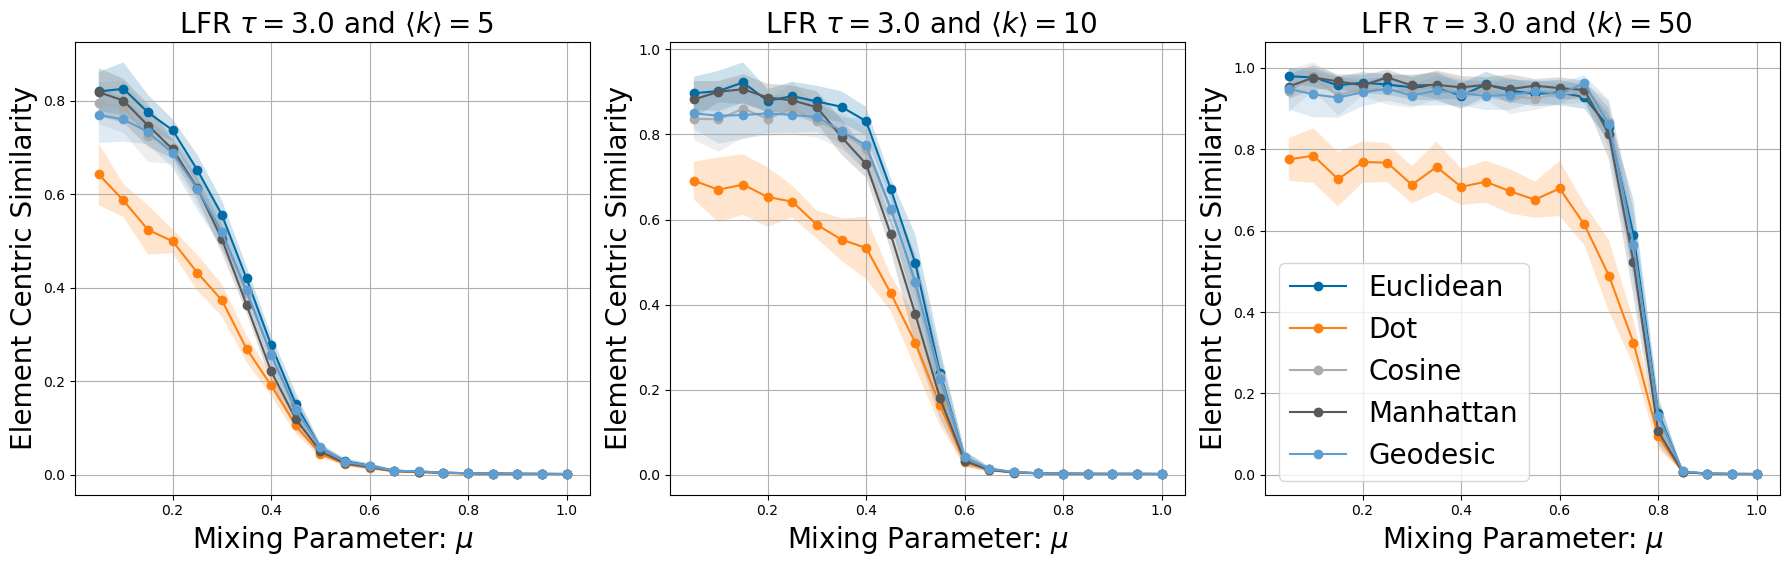

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('tableau-colorblind10')


# Define a dictionary for font sizes
font_sizes = {
    "title": 20,
    "axis_title": 20,
    "axis_label": 20,
    "legend": 20,
    "suptitle": 18,
}

# Load data and group by `mu` for each dimension

score_keys = ['kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine', 'kmeans_manhattan','kmeans_geodesic']
df_geo = {}
df = {}
for dim_key in [5, 10, 50]:  # Replace with actual dimension keys or loop over files
    plot_dir_data = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{dim_key}_3.0_minc50/kmeans_clustering_metric_change.txt"  # Adjust as needed
    dir_geo = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{dim_key}_3.0_minc50/kmeans_clustering_metric_geodesic.txt"

    #df[dim_key] = pd.read_csv(plot_dir_data)
    df[dim_key] = pd.read_csv(plot_dir_data,delimiter=',')
    df_geo[dim_key] = pd.read_csv(dir_geo,delimiter=',')
    df[dim_key] = df[dim_key].merge(df_geo[dim_key])
    df[dim_key] = df[dim_key].groupby('mu')[score_keys].agg(['mean', 'std']).reset_index()
    
# Create subplots for each dimension (5, 10, and 50)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each DataFrame in `df` and create a subplot
for ax, (dim_key, df_grouped) in zip(axes, df.items()):
    # Flatten MultiIndex columns for easier access
    df_grouped.columns = ['_'.join(col).strip() for col in df_grouped.columns.values]

    # Plot each score key on the current subplot
    for score_key in score_keys:
        mean_col = f"{score_key}_mean"
        std_col = f"{score_key}_std"
        
        # Extract mean and std for the current score key
        mean_values = df_grouped[mean_col]
        std_values = df_grouped[std_col]
        
        # Plot mean with standard deviation as shaded area
        ax.plot(mu_values, mean_values, '-o', label=score_key[7:].capitalize())
        ax.fill_between(mu_values, mean_values - std_values, mean_values + std_values, alpha=0.2)
    
    # Set labels, title, and grid for the subplot
    ax.set_ylabel("Element Centric Similarity", fontsize=font_sizes["axis_title"])
    ax.set_title(rf" LFR $\tau = 3.0$ and $\langle k \rangle = {dim_key}$", fontsize=font_sizes["title"])
    ax.grid(True)
    ax.set_xlabel(r'Mixing Parameter: $\mu$', fontsize=font_sizes["axis_title"])

# Add legend only once, setting font size
axes[-1].legend(loc='lower left', fontsize=font_sizes["legend"])

# Set the figure-level title
#fig.suptitle("Community Detection Performance of K-Means with Different Metrics on LFR Networks of Increasing Network Density",
#             fontsize=font_sizes["suptitle"])

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
#output_dir = os.path.dirname(file_path)
plt.savefig(f"/nobackup/gogandhi/alt_means_sans_k/results/Changing clustering metric/changing_kmeans_metric_across_dimensions.png", dpi=300, bbox_inches='tight')
plt.show()

In [56]:
mean_values.index

RangeIndex(start=0, stop=20, step=1)

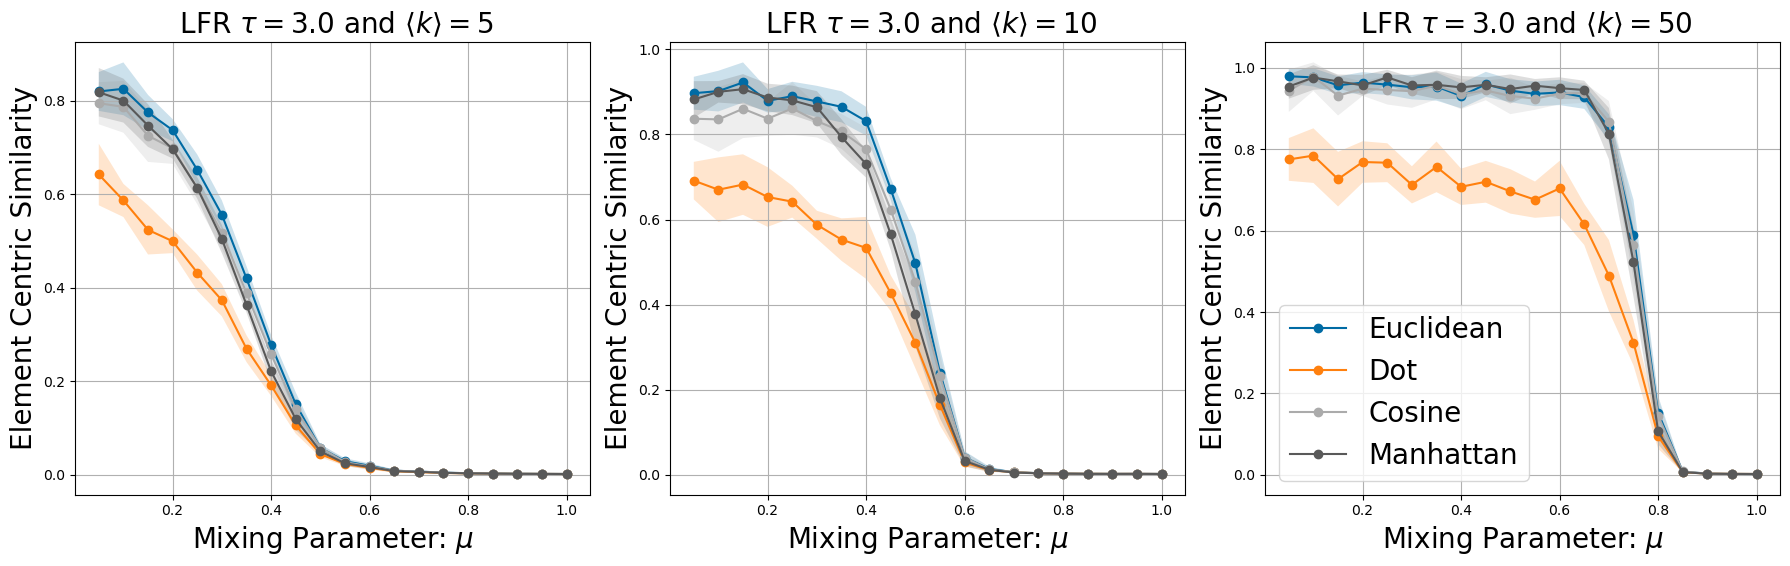

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('tableau-colorblind10')

# Define a dictionary for font sizes
font_sizes = {
    "title": 20,
    "axis_title": 20,
    "axis_label": 20,
    "legend": 20,
    "suptitle": 18,
}

# Define the path template for the data files and initialize the DataFrames
data_path_template = "/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_{}_3.0_minc50/kmeans_clustering_metric_change.txt"
df = {}

# Define score keys for plotting, including 'kmeans_geodesic'
score_keys = ['kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine', 'kmeans_manhattan', 'kmeans_geodesic']

# Load data and compute mean and std for each dimension
for dim_key in [5, 10, 50]:  # Loop through the different `k` values
    file_path = data_path_template.format(dim_key)
    df[dim_key] = pd.read_csv(file_path).groupby('mu')[score_keys].agg(['mean', 'std']).reset_index()

# Create subplots for each dimension (5, 10, and 50)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each DataFrame in `df` and create a subplot
for ax, (dim_key, df_grouped) in zip(axes, df.items()):
    # Flatten MultiIndex columns for easier access
    df_grouped.columns = ['_'.join(col).strip() for col in df_grouped.columns.values]

    # Plot each score key on the current subplot
    for score_key in score_keys:
        mean_col = f"{score_key}_mean"
        std_col = f"{score_key}_std"
        
        # Extract mean and std for the current score key
        mean_values = df_grouped[mean_col]
        std_values = df_grouped[std_col]
        
        # Plot mean with standard deviation as shaded area
        ax.plot(df_grouped['mu_'], mean_values, '-o', label=score_key[7:].capitalize())  # Use mu for the x-axis
        ax.fill_between(df_grouped['mu_'], mean_values - std_values, mean_values + std_values, alpha=0.2)
    
    # Set labels, title, and grid for the subplot
    ax.set_ylabel("Element Centric Similarity", fontsize=font_sizes["axis_title"])
    ax.set_title(rf"LFR $\tau = 3.0$ and $\langle k \rangle = {dim_key}$", fontsize=font_sizes["title"])
    ax.grid(True)
    ax.set_xlabel(r'Mixing Parameter: $\mu$', fontsize=font_sizes["axis_title"])

# Add legend only once, setting font size
axes[-1].legend(loc='lower left', fontsize=font_sizes["legend"])

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


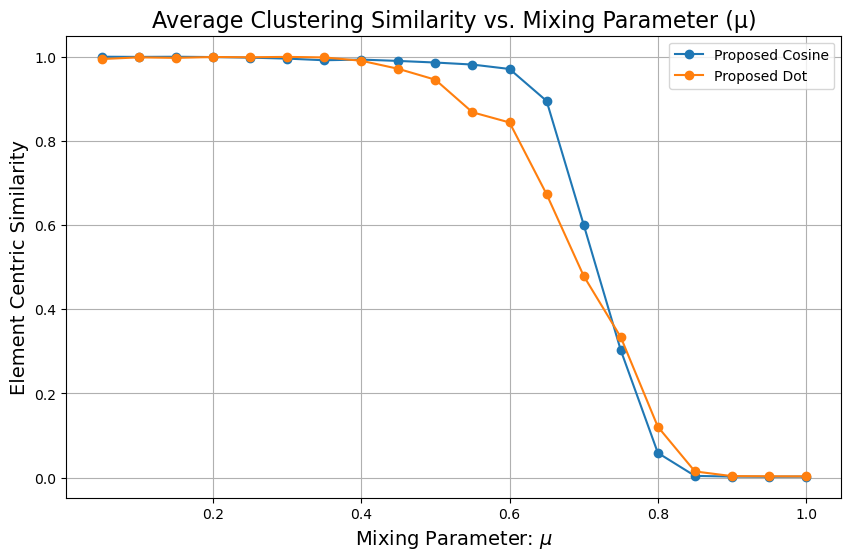

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
plot_dir_data = "/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_10000_50_3.0_minc50/altmeans_clustering_metric_change.txt"
df = pd.read_csv(plot_dir_data)

# Group by `mu` and calculate the mean of `proposed_cosine` and `proposed_dot` over all runs
df_avg = df.groupby('mu')[['proposed_cosine', 'proposed_dot']].mean().reset_index()

# Plot proposed_cosine and proposed_dot vs. mu
plt.figure(figsize=(10, 6))
plt.plot(df_avg['mu'], df_avg['proposed_cosine'], '-o', label='Proposed Cosine')
plt.plot(df_avg['mu'], df_avg['proposed_dot'], '-o', label='Proposed Dot')

# Add labels, title, legend, and grid
plt.xlabel(r'Mixing Parameter: $\mu$', fontsize=14)
plt.ylabel("Element Centric Similarity", fontsize=14)
plt.title("Average Clustering Similarity vs. Mixing Parameter (μ)", fontsize=16)
plt.legend()
plt.grid(True)

# Show and save plot
output_plot = "/nobackup/gogandhi/alt_means_sans_k/results/proposed_similarity_vs_mu.png"
plt.show()
